In [3]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns
sns.set()

# Import et EDA

In [4]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/jb75k2kxn5ajlcxsmvlnorxyj4pisx')

df.info()

df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
churn                         5000 non-null object
accountlength                 5000 non-null int64
internationalplan             5000 non-null object
voicemailplan                 5000 non-null object
numbervmailmessages           5000 non-null int64
totaldayminutes               5000 non-null float64
totaldaycalls                 5000 non-null int64
totaldaycharge                5000 non-null float64
totaleveminutes               5000 non-null float64
totalevecalls                 5000 non-null int64
totalevecharge                5000 non-null float64
totalnightminutes             5000 non-null float64
totalnightcalls               5000 non-null int64
totalnightcharge              5000 non-null float64
totalintlminutes              5000 non-null float64
totalintlcalls                5000 non-null int64
totalintlcharge               5000 non-null float64
numbercustomerservicecal

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,numbercustomerservicecalls
2708,Yes,132,no,no,0,291.2,104,49.50,234.2,132,19.91,191.7,87,8.63,8.9,3,2.40,1
3026,No,78,no,yes,32,210.3,116,35.75,192.2,83,16.34,246.1,92,11.07,10.8,4,2.92,6
1858,No,133,no,no,0,245.8,102,41.79,264.7,90,22.50,111.7,103,5.03,11.2,7,3.02,0


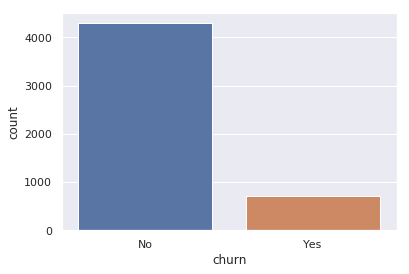

In [5]:
sns.countplot(df['churn'])
plt.show()

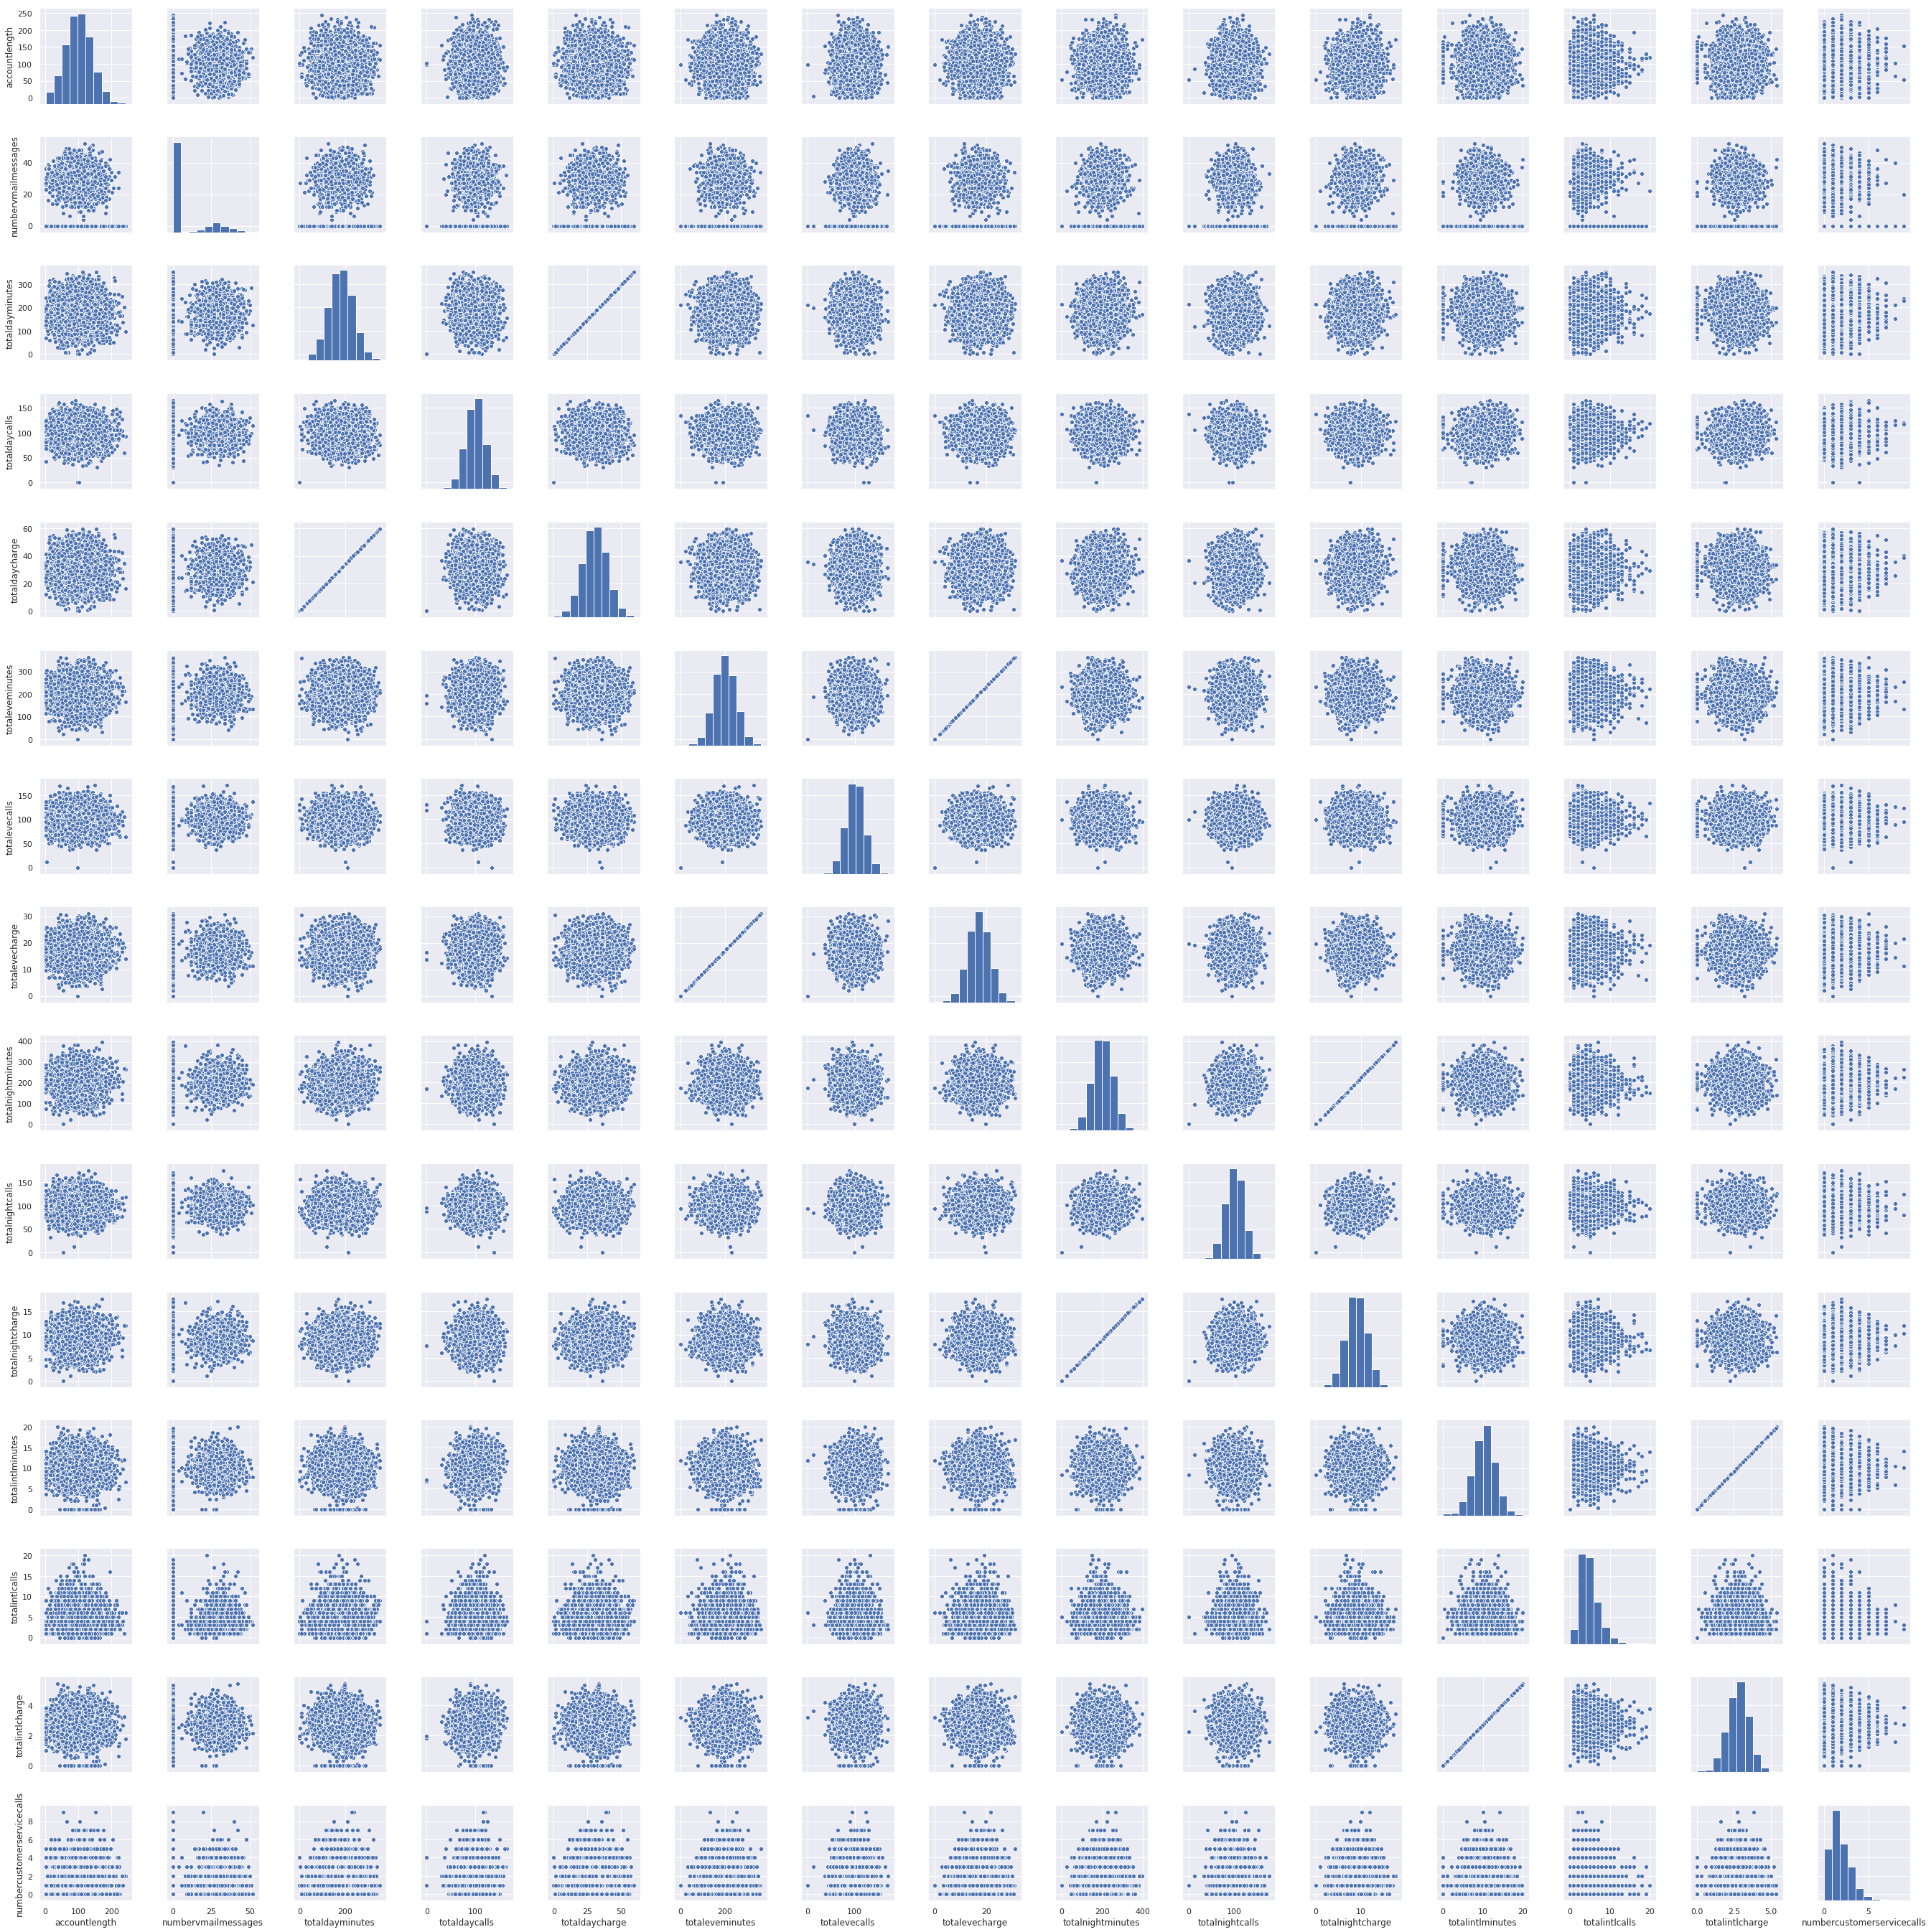

In [3]:
sns.pairplot(df)
plt.show()

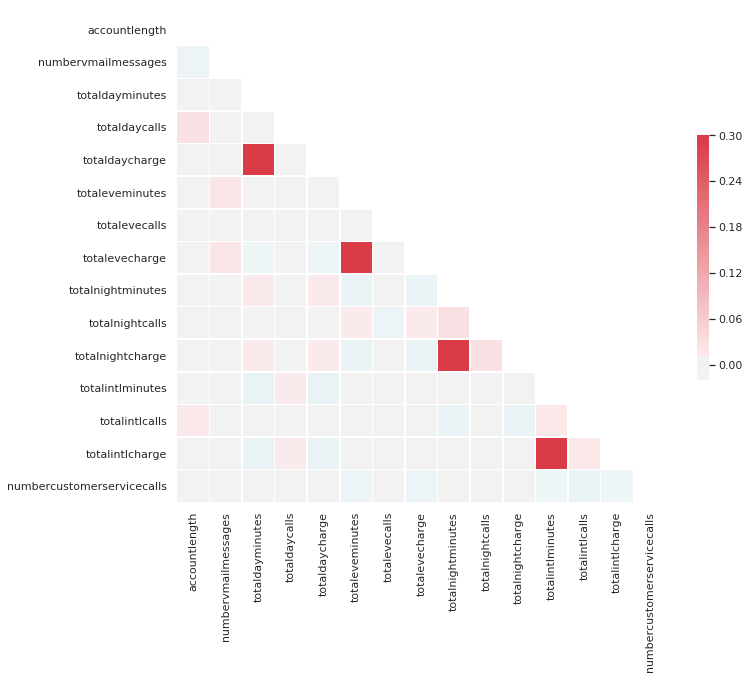

In [8]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style(style="white"):
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

In [8]:
X = df[[col for col in df if col != 'churn']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [9]:
drop_str_cols = ColumnTransformer(transformers=[
                                      ('drop_str_cols', 'drop', ['internationalplan', 'voicemailplan'])
                                  ],
                                  remainder='passthrough')

clf_lr_v0 = Pipeline(steps=[
    ('drop_str_cols', drop_str_cols),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])

clf_lr_v0.fit(X_train, y_train)

clf_lr_v0.score(X_test, y_test)

0.8626666666666667

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [11]:
enc_str_cols = ColumnTransformer(transformers=[
                                      ('enc_str_cols', OneHotEncoder(), ['internationalplan', 'voicemailplan'])
                                  ],
                                  remainder='passthrough')

clf_lr_v1 = Pipeline(steps=[
    ('enc_str_cols', enc_str_cols),
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])

clf_lr_v1.fit(X_train, y_train)

clf_lr_v1.score(X_test, y_test)

0.8706666666666667

In [16]:
nb = 10

df_res = pd.concat([
    pd.DataFrame({
        'classifier': 'clf_lr_v0',
        'score': cross_val_score(clf_lr_v0, X, y, cv=2)
    }),
    pd.DataFrame({
        'classifier': 'clf_lr_v1',
        'score': cross_val_score(clf_lr_v1, X, y, cv=2)
    })
])

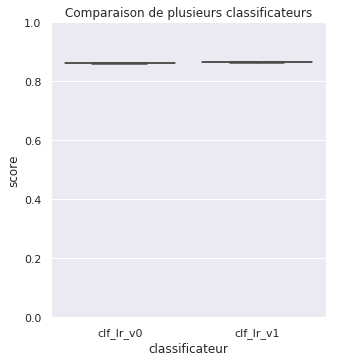

In [17]:
ax = sns.catplot(y='score', x='classifier', kind='box', data=df_res)

ax.set(
    title="Comparaison de plusieurs classificateurs",
    xlabel="classificateur",
    ylabel="score",
    ylim=[0, 1]
)

plt.show()

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
X = df[[col for col in df if col not in ['internationalplan', 'churn', 'voicemailplan']]]
y = df['churn']

nb = 10

df_res = pd.DataFrame()

for i in range(X.shape[1]):
    Xt = X.iloc[:, :i+1]
    
    clf = GradientBoostingClassifier()
    
    df_res = pd.concat([
        df_res,
        pd.DataFrame({
            'classifier': f'clf_nb_{i}',
            'score': cross_val_score(clf, Xt, y, cv=nb, scoring='roc_auc')
        })
    ])
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


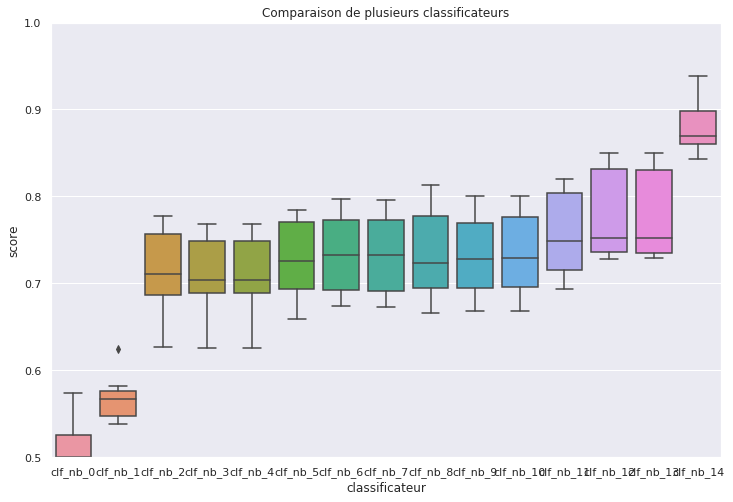

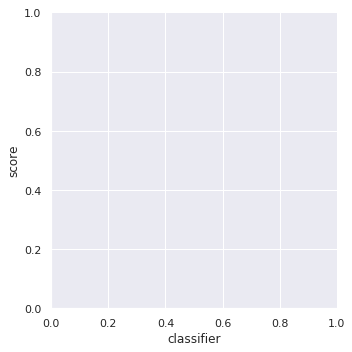

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.catplot(y='score', x='classifier', kind='box', data=df_res, ax=ax)

ax.set(
    title="Comparaison de plusieurs classificateurs",
    xlabel="classificateur",
    ylabel="score",
    ylim=[0.5, 1]
)

plt.show()

In [36]:
X.columns

Index(['accountlength', 'numbervmailmessages', 'totaldayminutes',
       'totaldaycalls', 'totaldaycharge', 'totaleveminutes', 'totalevecalls',
       'totalevecharge', 'totalnightminutes', 'totalnightcalls',
       'totalnightcharge', 'totalintlminutes', 'totalintlcalls',
       'totalintlcharge', 'numbercustomerservicecalls'],
      dtype='object')

In [37]:
X = df[[col for col in df if col != 'churn']]
y = df['churn']

nb = 10

enc_str_cols = ColumnTransformer(transformers=[
                                      ('enc_str_cols', OneHotEncoder(), ['internationalplan', 'voicemailplan'])
                                  ],
                                  remainder='passthrough')

clf = Pipeline(steps=[
    ('enc_str_cols', enc_str_cols),
    ('scale', StandardScaler()),
    ('grad', GradientBoostingClassifier())
])

scores = cross_val_score(clf, X, y, cv=nb, scoring='roc_auc')

In [38]:
np.mean(scores)

0.9197867232669067

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.96      0.99      0.97      1288
         Yes       0.91      0.77      0.83       212

   micro avg       0.96      0.96      0.96      1500
   macro avg       0.93      0.88      0.90      1500
weighted avg       0.95      0.96      0.95      1500



In [43]:
print(confusion_matrix(y_test, y_pred))

[[1271   17]
 [  49  163]]


In [46]:
163 / (49 + 163)

0.7688679245283019